# Laboratorium 2 - Analiza głównych składowych

## Preprocessing danych

In [123]:
import os
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [124]:
def load_images_from_folders(data_folders):
    images = []
    for folder in data_folders:
        folder_path = os.path.join("data", folder)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)
            images.append(img)
    return images

In [125]:
def convert_pictures(images):
    for i, img in enumerate(images):
        images[i] = img.convert('L') # konwersja do skali szarości
        images[i] = images[i].resize((224, 224)) # przeskalowanie do wymiarów 224x244x3
        images[i] = np.array(images[i]) # konwersja na format np.array
        images[i] = np.reshape(images[i], -1) # konwersja tablic 2d na wektory

    average_image = np.mean(images,axis=0)

    for i, img in enumerate(images):
        images[i] = images[i] - average_image # centrowanie zbioru

In [126]:
data_folders = ["mold", "mosaic", "septoria"]

In [127]:
images = load_images_from_folders(data_folders)
convert_pictures(images)
X = np.vstack(images)

In [128]:
print("Wymiary tablicy X ->", X.shape)

Wymiary tablicy X -> (60, 50176)


## Analiza głównych składowych

In [129]:
pca = PCA()
pca.fit(X)
X_pca = pca.transform(X)

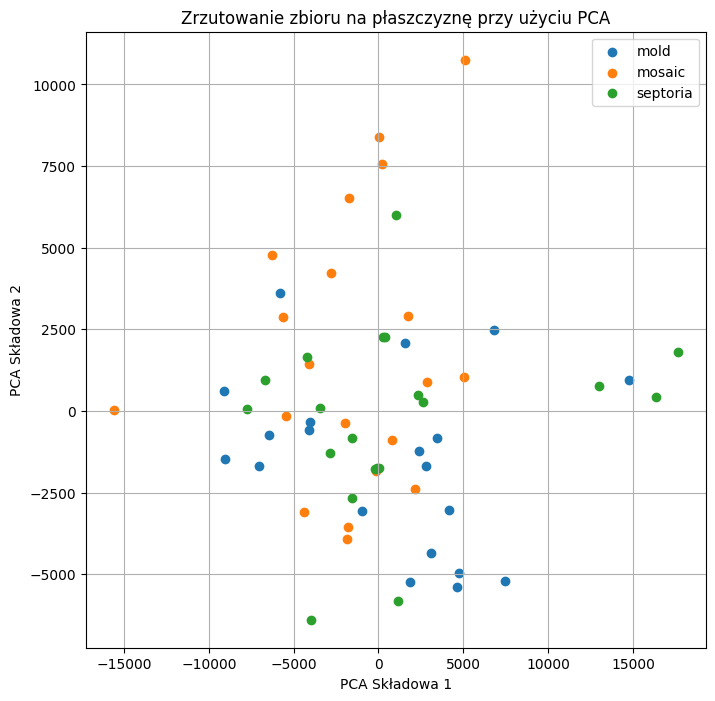

In [138]:
labels = ["mold", "mosaic", "septoria"]
plt.figure(figsize=(8, 8))
for i, label in enumerate(labels):
    plt.scatter(X_pca[i*20:(i+1)*20, 0], X_pca[i*20:(i+1)*20, 1], label=f'Klasa {label}')


plt.title('Zrzutowanie zbioru na płaszczyznę przy użyciu PCA')
plt.xlabel('PCA Składowa 1')
plt.ylabel('PCA Składowa 2')
plt.legend(labels)
plt.grid(True)
plt.savefig("graphs/pca_2d.png")


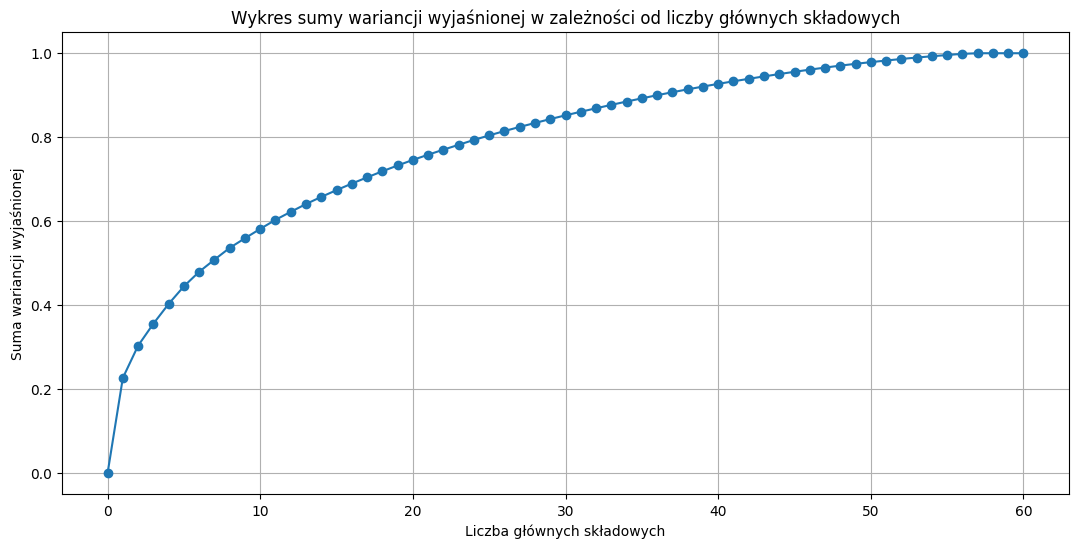

In [139]:
explained_variance_sum = []
for n in range(0, 61):
    explained_variance_sum.append(np.sum(pca.explained_variance_ratio_[:n]))
plt.figure(figsize=(13, 6))
plt.plot(np.arange(0, 61), explained_variance_sum, marker='o', linestyle='-')
plt.title('Wykres sumy wariancji wyjaśnionej w zależności od liczby głównych składowych')
plt.xlabel('Liczba głównych składowych')
plt.ylabel('Suma wariancji wyjaśnionej')
plt.grid(True)
plt.savefig("graphs/var_sum.png")
